In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "drive/MyDrive/EAI-2223-40"

/content/drive/MyDrive/EAI_Project


In [3]:
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
np.set_printoptions(precision=3, suppress=True)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.2 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [5]:
# Define segmentation areas
areas = {
    0: 'Non-tumor',
    1: 'Necrotic/core',
    2: 'Edema',
    3: 'Enhancing' # originally 4, converted to 3 later
}

# Each volume contains 155 slices, but we'll use 100 slices starting from slice 22
num_slices = 100
start_slice = 22
IMG_SIZE=128

In [6]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'


In [7]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


 
# we define dice coeffienct for each class seperately
# referenced from https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

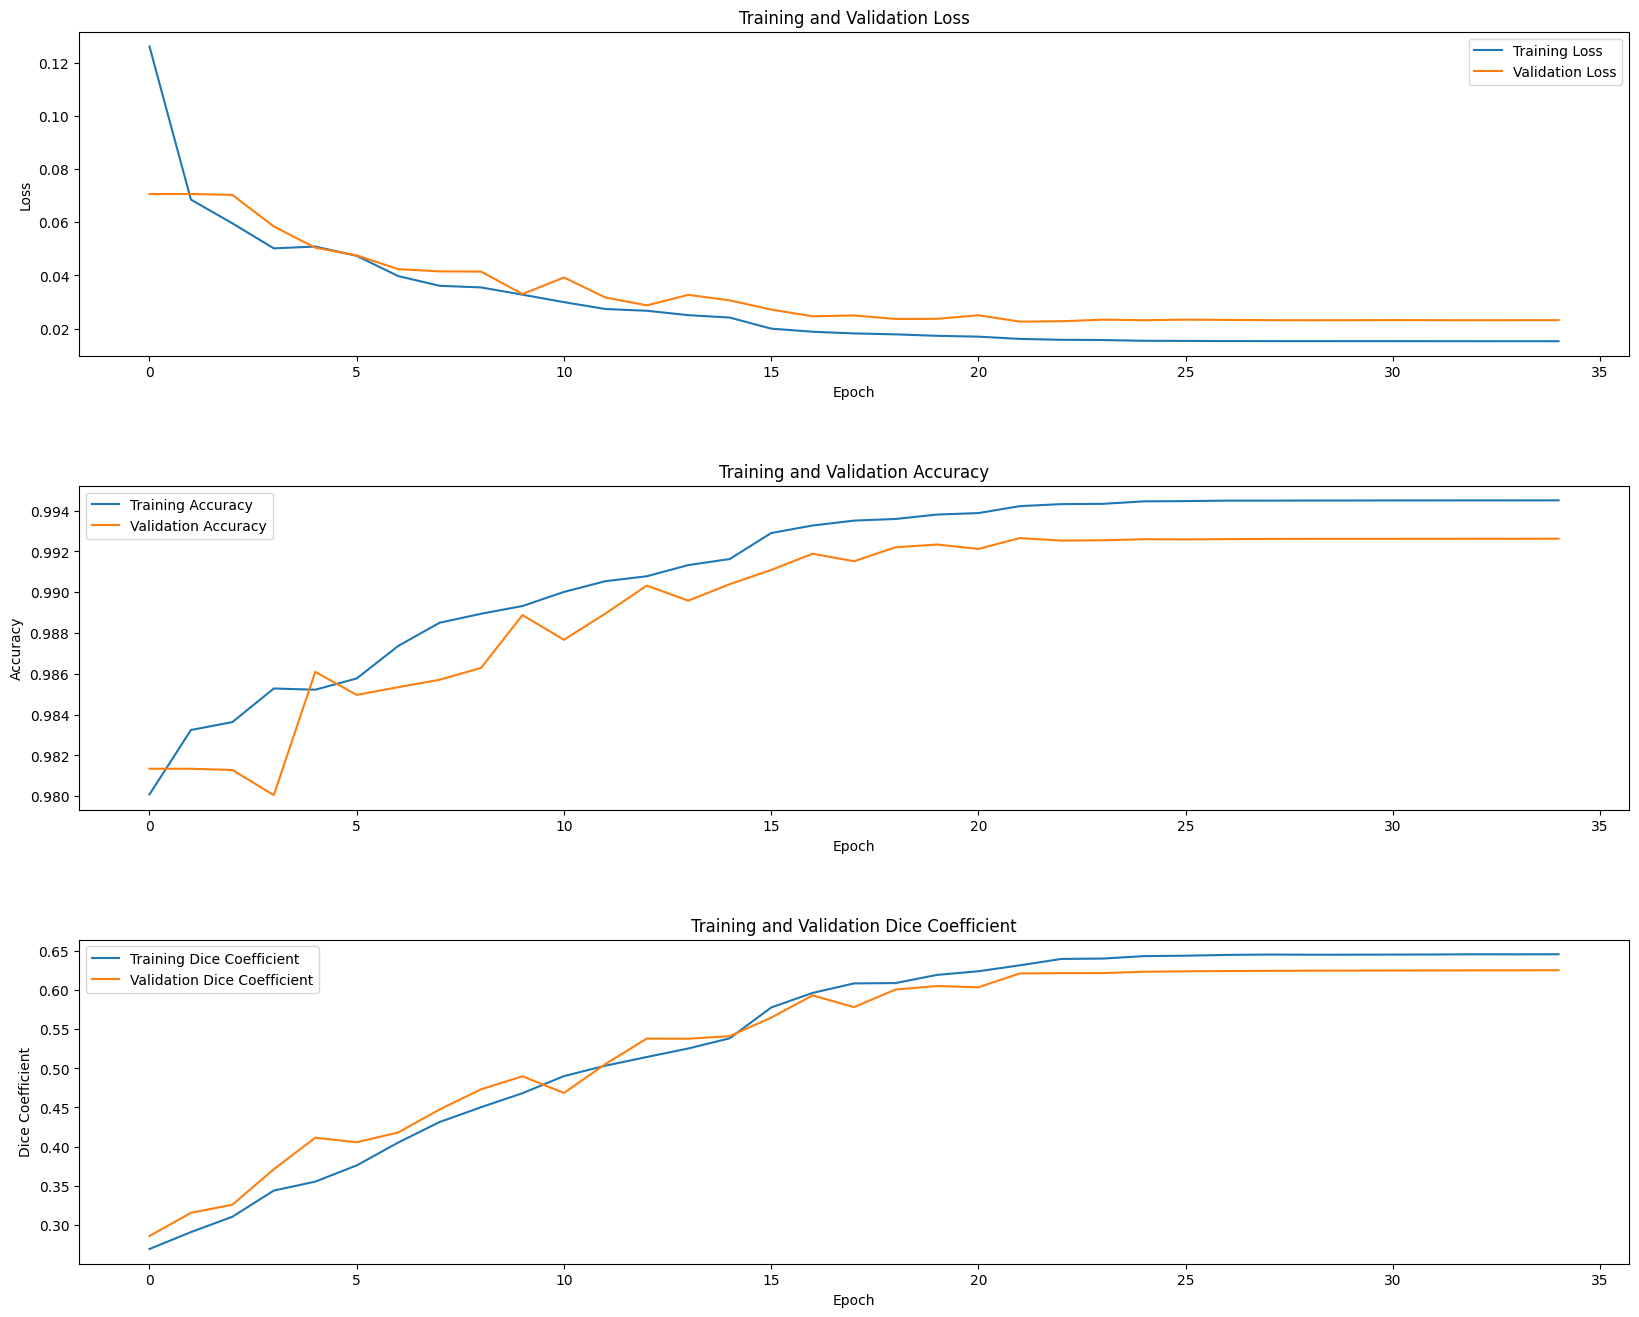

In [8]:
############ load trained model ################
model = keras.models.load_model('UnetModel.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('TrainingLogs.log', sep=',', engine='python')

hist=history

fig, axs = plt.subplots(3, figsize=(20, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

axs[0].plot(hist['loss'], label='Training Loss')
axs[0].plot(hist['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(hist['accuracy'], label='Training Accuracy')
axs[1].plot(hist['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(hist['dice_coef'], label='Training Dice Coefficient')
axs[2].plot(hist['val_dice_coef'], label='Validation Dice Coefficient')
axs[2].set_title('Training and Validation Dice Coefficient')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

plt.show()


In [9]:
# Get a list of directories with studies, excluding one with ill-formatted name
train_and_val_directories = []
for f in os.scandir(TRAIN_DATASET_PATH):
    if f.is_dir() and os.path.basename(f.path) != 'BraTS20_Training_355':
        train_and_val_directories.append(f.path)

# Convert directory paths to study IDs
train_and_test_ids = [os.path.basename(path) for path in train_and_val_directories]

# Split the study IDs into train, validation, and test sets
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.indexes = np.arange(len(list_IDs))
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        IDs = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(IDs)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, IDs):
        X = np.zeros((self.batch_size*num_slices, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*num_slices, 240, 240))
        Y = np.zeros((self.batch_size*num_slices, *self.dim, 4))

        for i, ID in enumerate(IDs):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)
            flair = nib.load(os.path.join(case_path, f'{ID}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{ID}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{ID}_seg.nii')).get_fdata()

            for j in range(num_slices):
                X[j + num_slices*i, :, :, 0] = cv2.resize(flair[:, :, j+start_slice], (IMG_SIZE, IMG_SIZE))
                X[j + num_slices*i, :, :, 1] = cv2.resize(ce[:, :, j+start_slice], (IMG_SIZE, IMG_SIZE))
                y[j + num_slices*i] = seg[:, :, j+start_slice]

        y[y==4] = 3
        y_resized = np.zeros((self.batch_size*num_slices, IMG_SIZE, IMG_SIZE))
        for j in range(y.shape[0]):
            y_resized[j,:,:] = cv2.resize(y[j,:,:], (IMG_SIZE, IMG_SIZE))
        mask = tf.one_hot(y_resized, 4)
        Y = mask

        return X / np.max(X), Y


In [11]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((num_slices, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
    for j in range(num_slices):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+start_slice], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+start_slice], (IMG_SIZE,IMG_SIZE))
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, slicestrt = 60):
    path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)
    #print(p.shape)
    core = p[:,:,:,1]

    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,slicestrt+start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,slicestrt+start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,slicestrt+start_slice], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[slicestrt,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[slicestrt,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{areas[1]} predicted')
    axarr[4].imshow(core[slicestrt,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{areas[2]} predicted')
    axarr[5].imshow(enhancing[slicestrt,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{areas[3]} predicted')
    plt.show()
    


In [12]:
test_generator=DataGenerator(test_ids)

In [13]:
def gradcampred(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((num_slices, IMG_SIZE, IMG_SIZE, 2))
  
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
    for j in range(num_slices):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+start_slice], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+start_slice], (IMG_SIZE,IMG_SIZE))
    return X/np.max(X)

In [14]:
def VizGradCAM(model, image, img_id,interpolant=0.4, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    original_img = np.asarray(image, dtype = np.float32)
    img = np.expand_dims(original_img,axis=0)
    pred = predictByPath(path,img_id)
    pred_index=None
    
    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = "conv2d_21"
    target_layer = model.get_layer(last_conv_layer)
    
    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
      gradient_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer("conv2d_21").output, model.output]
          )
      #pass the image through the base model and get the feature map  
      img=gradcampred(path,img_id)
      
      conv2d_out, prediction = gradient_model(img)
      
    
      #gradient() computes the gradient using operations recorded in context of this tape
      gradients = tape.gradient(prediction,conv2d_out)
      

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]
    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
   

    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    
    #resize to image size
    
    activation_map = cv2.resize(activation_map.numpy(), 
                                (img.shape[1], 
                                 img.shape[2]))
    
    
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
        
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)
    
  

    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    
    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    original_img=np.expand_dims(original_img,axis=2)
    cvt_heatmap = tf.keras.utils.img_to_array(cvt_heatmap)
    
    #enlarge plot
    plt.rcParams["figure.dpi"] = 100
    
    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
        plt.show()
        return cvt_heatmap
    else:
        return cvt_heatmap
        

4/4 [==============================] - 10s 2s/step


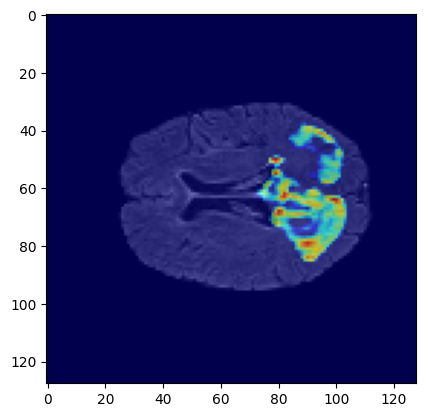

In [16]:
path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{test_ids[34][-3:]}"
origImage = nib.load(os.path.join(path, f'BraTS20_Training_{test_ids[34][-3:]}_flair.nii')).get_fdata()
origImage=cv2.resize(origImage[:,:,60+22], (IMG_SIZE, IMG_SIZE))
#origImage=cv2.rotate(origImage,cv2.ROTATE_180)
model.layers[-1].activation = None
heatmapret=VizGradCAM(model, origImage, test_ids[34][-3:] , plot_results=True)

4/4 [==============================] - 13s 3s/step


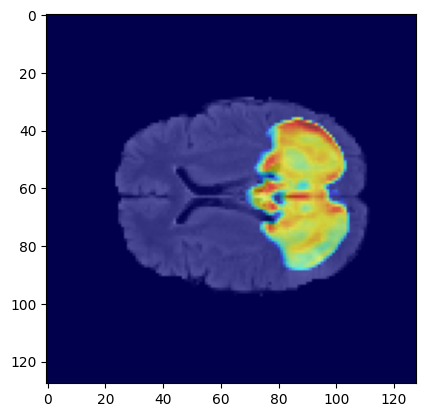

In [21]:
path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{test_ids[37][-3:]}"
origImage = nib.load(os.path.join(path, f'BraTS20_Training_{test_ids[37][-3:]}_flair.nii')).get_fdata()
origImage=cv2.resize(origImage[:,:,60+22], (IMG_SIZE, IMG_SIZE))
#origImage=cv2.rotate(origImage,cv2.ROTATE_180)
model.layers[-1].activation = None
heatmapret=VizGradCAM(model, origImage, test_ids[37][-3:] , plot_results=True)

4/4 [==============================] - 18s 4s/step


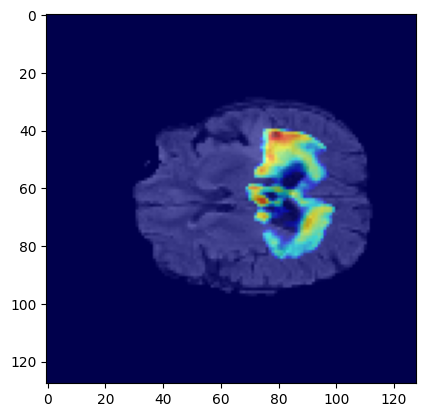

In [ ]:
path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{test_ids[17][-3:]}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{test_ids[17][-3:]}_seg.nii')).get_fdata()
origImage = nib.load(os.path.join(path, f'BraTS20_Training_{test_ids[17][-3:]}_flair.nii')).get_fdata()
#p = predictByPath(path,test_ids[33][-3:])
origImage=cv2.resize(origImage[:,:,60+22], (IMG_SIZE, IMG_SIZE))
#origImage=cv2.rotate(origImage,cv2.ROTATE_180)
model.layers[-1].activation = None
heatmapret=VizGradCAM(model, origImage, test_ids[17][-3:] , plot_results=True)

4/4 [==============================] - 16s 3s/step


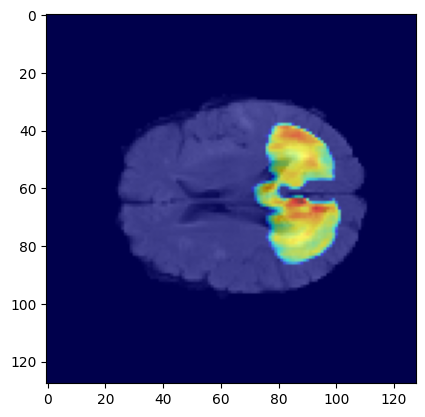

In [ ]:
path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{test_ids[19][-3:]}"
origImage = nib.load(os.path.join(path, f'BraTS20_Training_{test_ids[19][-3:]}_flair.nii')).get_fdata()
origImage=cv2.resize(origImage[:,:,60+22], (IMG_SIZE, IMG_SIZE))
#origImage=cv2.rotate(origImage,cv2.ROTATE_180)
model.layers[-1].activation = None
heatmapret=VizGradCAM(model, origImage, test_ids[19][-3:] , plot_results=True)